<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_models_on_important_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sqlite3
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


In [4]:
#Load all pickled data
KNN_imputed_trainX = pickle.load(open("KNN_imputed_trainX_70.pkl", "rb"))
KNN_imputed_testX_df = pickle.load(open("KNN_imputed_testX_df_70.pkl", "rb"))
train_y = pickle.load(open("diabetes_train_y.pkl", "rb"))
test_y = pickle.load(open("diabetes_test_y.pkl", "rb"))

trainX_imp_features = pickle.load(open("train_X_after_BE.pkl", "rb"))
testX_imp_features  = pickle.load(open("test_X_after_BE.pkl", "rb"))

pca_95per_train = pickle.load(open("pca_95per_train_70.pkl", "rb"))
pca_97per_train = pickle.load(open("pca_97per_train_70.pkl", "rb"))
pca_99per_train = pickle.load(open("pca_99per_train_70.pkl", "rb"))

pca_95per_test = pickle.load(open("pca_95per_test_70.pkl", "rb"))
pca_97per_test = pickle.load(open("pca_97per_test_70.pkl", "rb"))
pca_99per_test = pickle.load(open("pca_99per_test_70.pkl", "rb"))

In [5]:
#standardize data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(KNN_imputed_trainX)
scaled_test_df = scaler.fit_transform(KNN_imputed_testX_df)

In [6]:
#standardize data
scaled_imp_features_df = scaler.fit_transform(trainX_imp_features)
scaled_imp_features_test_df = scaler.transform(testX_imp_features)

In [7]:
pca_97per_train_scaled = scaler.fit_transform(pca_97per_train)
pca_97per_test_scaled = scaler.transform(pca_97per_test)

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import accuracy_score
RF_Cl=RandomForestClassifier(n_estimators=200)
start = time.time()
RF_Cl.fit(scaled_imp_features_df,train_y) #training
end = time.time()
print("Time taken to train data with RFC in seconds :",end-start)

Time taken to train data with RFC in seconds : 149.42572355270386


In [ ]:
RF_Cl.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [ ]:
y_pred = RF_Cl.predict(scaled_imp_features_test_df) #predicting on the test set

In [ ]:
from sklearn import metrics
rfc_test_score = metrics.accuracy_score(test_y, y_pred)
print("Accuracy of RFC model:",rfc_test_score)

Accuracy of RFC model: 0.8246004917025199


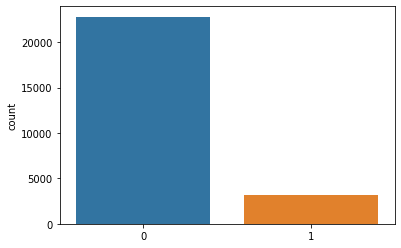

In [ ]:
sns.countplot(y_pred)

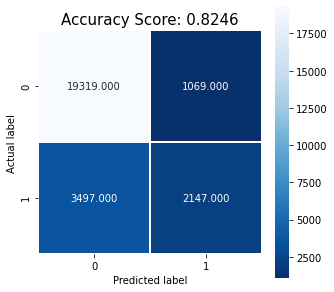

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(rfc_test_score)
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.89     20388
           1       0.67      0.38      0.48      5644

    accuracy                           0.82     26032
   macro avg       0.76      0.66      0.69     26032
weighted avg       0.81      0.82      0.81     26032



# XGB

In [ ]:
xg_cl = xgb.XGBClassifier(learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
xg_cl.fit(scaled_imp_features_df,train_y)
preds = xg_cl.predict(scaled_imp_features_test_df)

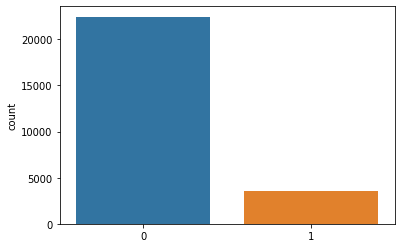

In [ ]:
sns.countplot(preds)

In [ ]:
from sklearn import metrics
xgb_accuracy = metrics.accuracy_score(test_y, preds)
print("Accuracy of XGB model:",xgb_accuracy)

Accuracy of XGB model: 0.8269821757836509


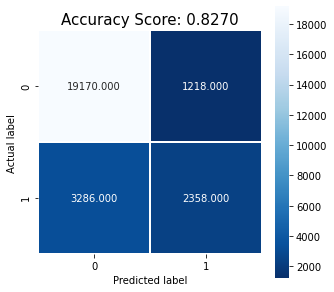

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(xgb_accuracy)
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     20388
           1       0.66      0.42      0.51      5644

    accuracy                           0.83     26032
   macro avg       0.76      0.68      0.70     26032
weighted avg       0.81      0.83      0.81     26032



# Light GBM

### LGBM on entire dataset

In [12]:
clf = lgb.LGBMClassifier(n_estimators=100, random_state=0)
%time clf.fit(scaled_df, train_y)

CPU times: user 20.6 s, sys: 102 ms, total: 20.7 s
Wall time: 10.8 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [13]:
train_score = clf.score(scaled_df, train_y)
train_score

0.8445810324129652

In [14]:
# predict the results
lgb_y_pred=clf.predict(scaled_test_df)

In [15]:
lgb_accuracy=accuracy_score(lgb_y_pred, test_y)
print('LightGBM Model accuracy score: {0:0.4f}'.format(lgb_accuracy))

LightGBM Model accuracy score: 0.7330


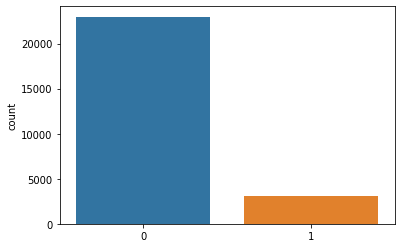

In [16]:
sns.countplot(lgb_y_pred)

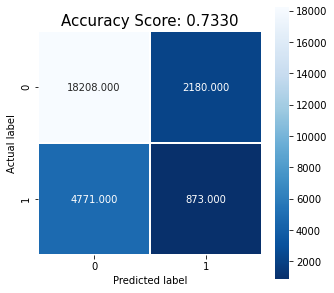

In [17]:
#show confusion matrix
cm = confusion_matrix(test_y, lgb_y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(lgb_accuracy)
plt.title(all_sample_title, size = 15);

In [18]:
print(classification_report(test_y, lgb_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84     20388
           1       0.29      0.15      0.20      5644

    accuracy                           0.73     26032
   macro avg       0.54      0.52      0.52     26032
weighted avg       0.68      0.73      0.70     26032



### LGBM on important features

In [19]:
lgbm_clf_imp = lgb.LGBMClassifier(n_estimators=100, random_state=0)
%time lgbm_clf_imp.fit(scaled_imp_features_df, train_y)

CPU times: user 12.6 s, sys: 56.8 ms, total: 12.6 s
Wall time: 6.65 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [20]:
train_score_imp = lgbm_clf_imp.score(scaled_imp_features_df, train_y)
train_score_imp

0.8437743097238896

In [21]:
# predict the results
lgb_y_pred_imp = lgbm_clf_imp.predict(scaled_imp_features_test_df)

In [22]:
lgb_accuracy_imp = accuracy_score(test_y, lgb_y_pred_imp)
print('LightGBM Model accuracy score: {0:0.4f}'.format(lgb_accuracy_imp))

LightGBM Model accuracy score: 0.8288


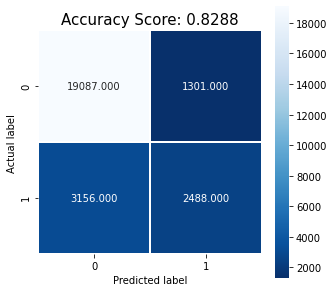

In [23]:
#show confusion matrix
cm = confusion_matrix(test_y, lgb_y_pred_imp)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(lgb_accuracy_imp)
plt.title(all_sample_title, size = 15);

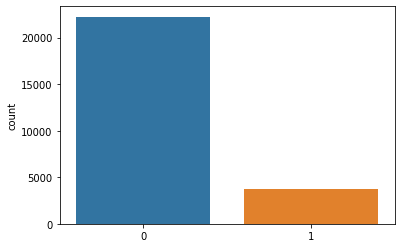

In [24]:
sns.countplot(lgb_y_pred_imp)

In [25]:
print(classification_report(test_y, lgb_y_pred_imp))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     20388
           1       0.66      0.44      0.53      5644

    accuracy                           0.83     26032
   macro avg       0.76      0.69      0.71     26032
weighted avg       0.81      0.83      0.82     26032



### LGBM on PCA

In [26]:
lgbm_clf_pca = lgb.LGBMClassifier(n_estimators=100, random_state=0)
%time lgbm_clf_pca.fit(pca_97per_train_scaled, train_y)

CPU times: user 13.8 s, sys: 132 ms, total: 13.9 s
Wall time: 7.34 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [27]:
train_score_pca = lgbm_clf_pca.score(pca_97per_train_scaled, train_y)
train_score_pca

0.8308955582232893

In [28]:
# predict the results
lgb_y_pred_pca = lgbm_clf_pca.predict(pca_97per_test_scaled)

In [29]:
lgb_accuracy_pca = accuracy_score(test_y, lgb_y_pred_pca)
print('LightGBM Model accuracy score: {0:0.4f}'.format(lgb_accuracy_pca))

LightGBM Model accuracy score: 0.4027


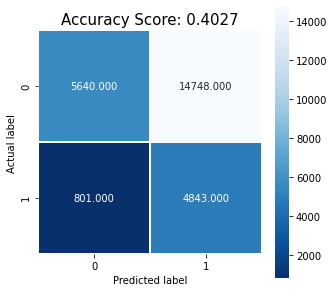

In [30]:
#show confusion matrix
cm = confusion_matrix(test_y, lgb_y_pred_pca)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(lgb_accuracy_pca)
plt.title(all_sample_title, size = 15);

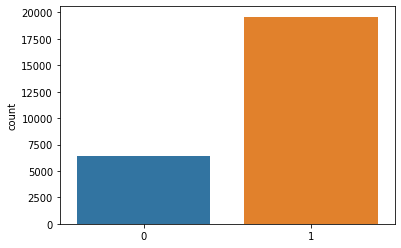

In [31]:
sns.countplot(lgb_y_pred_pca)

In [32]:
print(classification_report(test_y, lgb_y_pred_pca))

              precision    recall  f1-score   support

           0       0.88      0.28      0.42     20388
           1       0.25      0.86      0.38      5644

    accuracy                           0.40     26032
   macro avg       0.56      0.57      0.40     26032
weighted avg       0.74      0.40      0.41     26032



# Neural Network - Keras

In [ ]:
def keras_nn(nn_model, train_X, train_y, test_X, test_y, epochs):
    # Model output shape
    print("Model output shape",nn_model.output_shape)

    # Model summary
    print("Model summary",nn_model.summary())

    # Model config
    print("Model configuration",nn_model.get_config())
    
    # List all weight tensors 
    print("Model weights",nn_model.get_weights())

    nn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
    %time nn_model.fit(train_X, train_y, epochs=epochs, batch_size=1, verbose=1)

    return nn_model

### on the entire dataset

In [ ]:
# Initialize the constructor
nn_model = Sequential()

# Add an input layer 
nn_model.add(Dense(109, activation='relu', input_dim=109))

# Add two hidden layers 
nn_model.add(Dense(50, activation='relu'))
nn_model.add(Dense(20, activation='relu'))

# Add an output layer 
nn_model.add(Dense(1, activation='sigmoid'))

nn_model = keras_nn(nn_model, KNN_imputed_trainX, train_y, 
                                        KNN_imputed_testX_df, test_y, epochs=20)

Model output shape (None, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 109)               11990     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5500      
_________________________________________________________________
dense_9 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 18,531
Trainable params: 18,531
Non-trainable params: 0
_________________________________________________________________
Model summary None
Model configuration {'name': 'sequential_2', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 109), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_7

In [ ]:
%time nn_y_pred = nn_model.predict_classes(KNN_imputed_testX_df)
pickle.dump(nn_y_pred, open("nn_y_pred.pkl", "wb"))  
nn_y_pred = pickle.load(open("nn_y_pred.pkl", "rb"))
nn_y_pred = nn_y_pred.flatten()

CPU times: user 963 ms, sys: 90 ms, total: 1.05 s
Wall time: 914 ms


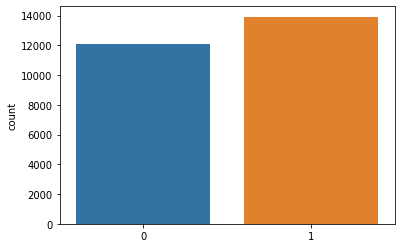

In [ ]:
sns.countplot(nn_y_pred)

In [ ]:
nn_scores = nn_model.evaluate(scaled_test_df, test_y, verbose=0)
print('Accuracy on test data: {}'.format(nn_scores[1]))  

Accuracy on test data: 0.7743162512779236


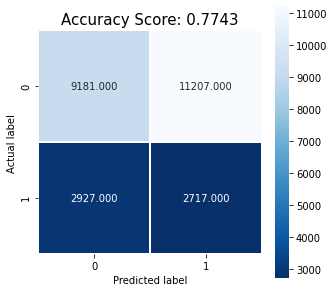

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, nn_y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(nn_scores[1])
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, nn_y_pred))

              precision    recall  f1-score   support

           0       0.76      0.45      0.57     20388
           1       0.20      0.48      0.28      5644

    accuracy                           0.46     26032
   macro avg       0.48      0.47      0.42     26032
weighted avg       0.64      0.46      0.50     26032



### on important features

In [ ]:
# Initialize the constructor
nn_model_imp = Sequential()

# Add an input layer 
nn_model_imp.add(Dense(66, activation='relu', input_dim=66))

# Add two hidden layers 
nn_model_imp.add(Dense(20, activation='relu'))

# Add an output layer 
nn_model_imp.add(Dense(1, activation='sigmoid'))

nn_model_imp = keras_nn(nn_model_imp, scaled_imp_features_df, train_y, 
                                        scaled_imp_features_test_df, test_y, epochs=20)

Model output shape (None, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 66)                4422      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1340      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 5,783
Trainable params: 5,783
Non-trainable params: 0
_________________________________________________________________
Model summary None
Model configuration {'name': 'sequential_1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 66), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_3_input'}}, {'class_name': 'Dense', 'config': {'name': 'dense_3', 'trainable': True, 'batch_input_shape': (None, 66), 'dtype': 'float32'

In [ ]:
%time nn_y_pred_imp = nn_model_imp.predict_classes(scaled_imp_features_test_df)
pickle.dump(nn_y_pred_imp, open("nn_y_pred_imp.pkl", "wb"))  
nn_y_pred_imp = pickle.load(open("nn_y_pred_imp.pkl", "rb"))
nn_y_pred_imp = nn_y_pred_imp.flatten()

CPU times: user 619 ms, sys: 70.7 ms, total: 690 ms
Wall time: 579 ms


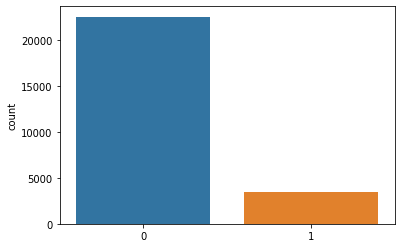

In [ ]:
sns.countplot(nn_y_pred_imp)

In [ ]:
nn_scores_imp = nn_model_imp.evaluate(scaled_imp_features_test_df, test_y, verbose=0)
print('Accuracy on test data: {}'.format(nn_scores_imp[1]))  

Accuracy on test data: 0.8232944011688232


Text(0.5, 1.0, 'Accuracy Score: 0.8233')

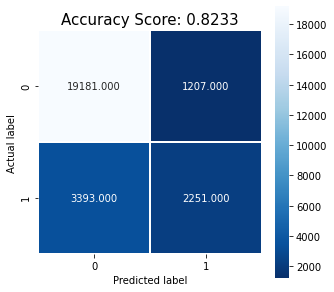

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, nn_y_pred_imp)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(nn_scores_imp[1])
plt.title(all_sample_title, size = 15)

In [ ]:
print(classification_report(test_y, nn_y_pred_imp))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     20388
           1       0.65      0.40      0.49      5644

    accuracy                           0.82     26032
   macro avg       0.75      0.67      0.69     26032
weighted avg       0.81      0.82      0.81     26032



### on PCA

In [ ]:
pca_97per_train_scaled.shape

(104125, 63)

In [ ]:
# Initialize the constructor
nn_model_pca = Sequential()

# Add an input layer 
nn_model_pca.add(Dense(63, activation='relu', input_dim=63))

# Add two hidden layers 
nn_model_pca.add(Dense(20, activation='relu'))

# Add an output layer 
nn_model_pca.add(Dense(1, activation='sigmoid'))

nn_model_pca = keras_nn(nn_model_pca, pca_97per_train_scaled, train_y, 
                                        pca_97per_test_scaled, test_y, epochs=20)

Model output shape (None, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 63)                4032      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1280      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 5,333
Trainable params: 5,333
Non-trainable params: 0
_________________________________________________________________
Model summary None
Model configuration {'name': 'sequential', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 63), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_input'}}, {'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 63), 'dtype': 'float32', 'units

In [ ]:
%time nn_y_pred_pca = nn_model_pca.predict_classes(pca_97per_test_scaled)
pickle.dump(nn_y_pred_pca, open("nn_y_pred_pca.pkl", "wb"))  
nn_y_pred_pca = pickle.load(open("nn_y_pred_pca.pkl", "rb"))
nn_y_pred_pca = nn_y_pred_pca.flatten()

CPU times: user 661 ms, sys: 60.3 ms, total: 721 ms
Wall time: 648 ms


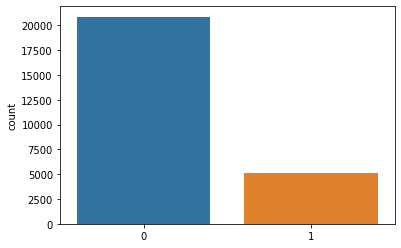

In [ ]:
sns.countplot(nn_y_pred_pca)

In [ ]:
nn_scores_pca = nn_model_pca.evaluate(pca_97per_test_scaled, test_y, verbose=0)
print('Accuracy on test data: {}'.format(nn_scores_pca[1]))  

Accuracy on test data: 0.6286493539810181


Text(0.5, 1.0, 'Accuracy Score: 0.6286')

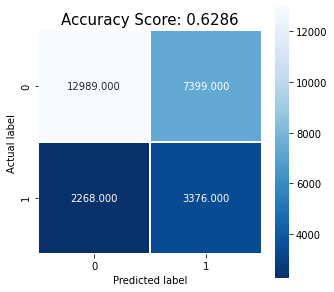

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, nn_y_pred_pca)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(nn_scores_pca[1])
plt.title(all_sample_title, size = 15)

In [ ]:
print(classification_report(test_y, nn_y_pred_pca))

              precision    recall  f1-score   support

           0       0.85      0.64      0.73     20388
           1       0.31      0.60      0.41      5644

    accuracy                           0.63     26032
   macro avg       0.58      0.62      0.57     26032
weighted avg       0.73      0.63      0.66     26032



#Logistic Regression

Accuracy on test data: 0.7377842655193608


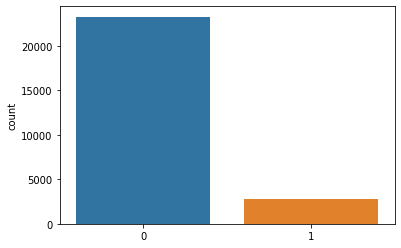

In [ ]:
# Apply logistic regression
clf = LogisticRegression(random_state=0, max_iter=200).fit(scaled_df, train_y)
pred = clf.predict(scaled_test_df)
score = clf.score(scaled_test_df,test_y)
print('Accuracy on test data: {}'.format(score))  
sns.countplot(pred)


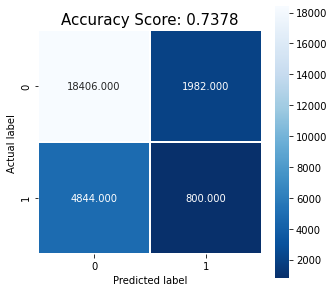

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84     20388
           1       0.29      0.14      0.19      5644

    accuracy                           0.74     26032
   macro avg       0.54      0.52      0.52     26032
weighted avg       0.68      0.74      0.70     26032



In [ ]:
# Hyperparameter tuning
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iter = [200,300]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter = max_iter)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
grid_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(scaled_df, train_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.811803 using {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 10}
0.811693 (0.001834) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 0.01}
0.811798 (0.001823) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 300, 'C': 1.0}
0.811717 (0.001738) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'C': 0.01}
0.811693 (0.001834) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 0.01}
0.811794 (0.001823) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'C': 100}
0.811789 (0.001818) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'C': 10}
0.811717 (0.001852) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'C': 0.1}
0.811803 (0.001823) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 10}
0.811794 (0.001823) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'C': 100}
0.811803 (0.001811) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 30

## Logistic Regression on PCA data

In [ ]:
lgreg_pca = LogisticRegression(max_iter=200)
scaler = StandardScaler()
pca_97per_train_scaled = scaler.fit_transform(pca_97per_train)
pca_97per_test_scaled = scaler.fit_transform(pca_97per_test)
%time lgreg_pca.fit(pca_97per_train_scaled, train_y)

CPU times: user 390 ms, sys: 225 ms, total: 615 ms
Wall time: 378 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# predict the results
lgreg_pca_y_pred=lgreg_pca.predict(pca_97per_test_scaled)
lgreg_pca_accuracy=accuracy_score(lgreg_pca_y_pred, test_y)
print('Logistic Regression Model accuracy score: {0:0.4f}'.format(lgreg_pca_accuracy))

Logistic Regression Model accuracy score: 0.8049


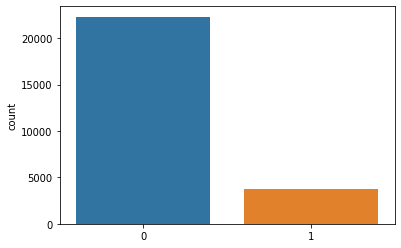

In [ ]:
sns.countplot(lgreg_pca_y_pred)


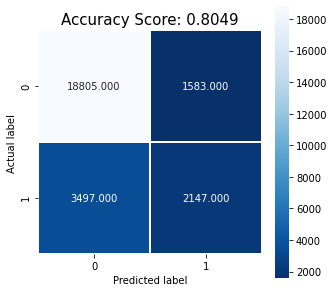

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, lgreg_pca_y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(lgreg_pca_accuracy)
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, lgreg_pca_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     20388
           1       0.58      0.38      0.46      5644

    accuracy                           0.80     26032
   macro avg       0.71      0.65      0.67     26032
weighted avg       0.79      0.80      0.79     26032



In [ ]:
lgreg_feat = LogisticRegression(max_iter=200)
%time lgreg_feat.fit(trainX_imp_features, train_y)
lgreg_feat_imp = lgreg_feat.predict(testX_imp_features)

CPU times: user 9.93 s, sys: 2.91 s, total: 12.8 s
Wall time: 6.62 s


In [ ]:
lgr_accuracy_imp = accuracy_score(test_y, lgreg_feat_imp)
print('Logistic Model accuracy score: {0:0.4f}'.format(lgr_accuracy_imp))

Logistic Model accuracy score: 0.8066


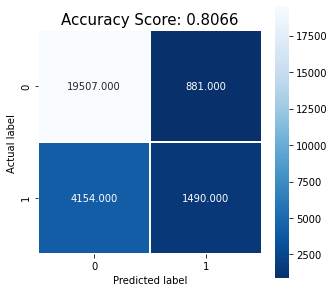

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, lgreg_feat_imp)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(lgr_accuracy_imp)
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, lgreg_feat_imp))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89     20388
           1       0.63      0.26      0.37      5644

    accuracy                           0.81     26032
   macro avg       0.73      0.61      0.63     26032
weighted avg       0.78      0.81      0.77     26032



##**RFC on PCA data**

In [ ]:
scaler = StandardScaler()
pca_97per_train_scaled = scaler.fit_transform(pca_97per_train)
pca_97per_test_scaled = scaler.fit_transform(pca_97per_test)

In [ ]:
RF_Cl_pca=RandomForestClassifier(n_estimators=200)
%time
RF_Cl_pca.fit(pca_97per_train_scaled,train_y) #training

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = RF_Cl_pca.predict(pca_97per_test_scaled) #predicting on the test set

In [ ]:
from sklearn import metrics
rfc_test_score = metrics.accuracy_score(test_y, y_pred)
print("Accuracy of RFC model:",rfc_test_score)

Accuracy of RFC model: 0.801820835894284


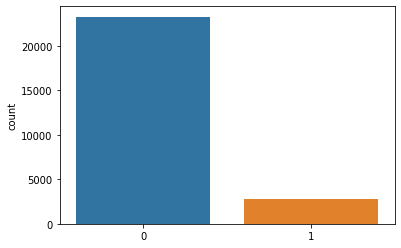

In [ ]:
sns.countplot(y_pred)

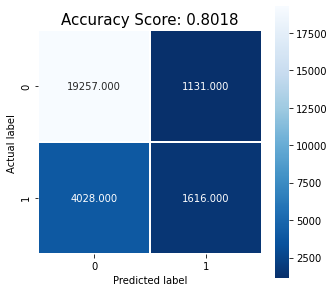

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(rfc_test_score)
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88     20388
           1       0.59      0.29      0.39      5644

    accuracy                           0.80     26032
   macro avg       0.71      0.62      0.63     26032
weighted avg       0.78      0.80      0.77     26032



##**XGB with PCA**

In [ ]:
xg_cl = xgb.XGBClassifier(learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
xg_cl.fit(pca_97per_train_scaled,train_y)
preds = xg_cl.predict(pca_97per_test_scaled)

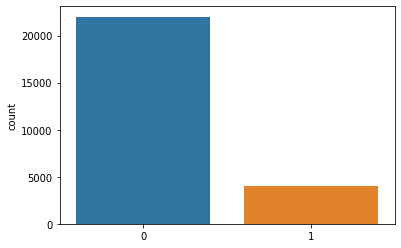

In [ ]:
sns.countplot(preds)

In [ ]:
from sklearn import metrics
xgb_accuracy = metrics.accuracy_score(test_y, preds)
print("Accuracy of XGB model:",xgb_accuracy)

Accuracy of XGB model: 0.8043945912722803


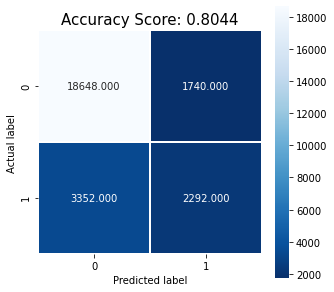

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(xgb_accuracy)
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     20388
           1       0.57      0.41      0.47      5644

    accuracy                           0.80     26032
   macro avg       0.71      0.66      0.68     26032
weighted avg       0.79      0.80      0.79     26032

